## 第一部分：什么是欧洲足球数据库？

作者：带球小弟

数据网站Kaggle上的[欧洲足球数据库](https://www.kaggle.com/hugomathien/soccer)是本人所能找到可以直接拿来使用的最全的足球数据。这一数据库可以用来做足球相关的数据挖掘和机器学习应用。

这一部分旨在对这一数据库有一个整体了解，为之后的应用做准备。

### 主要发现

* 欧洲职业联赛球员中出现了“相对年龄效应”，或者叫做对于球员出生月份的偏见：一月份出生的球员最多，然后随着月份的增大而减少，十二月份出生的球员最少。
* 欧洲职业足球运动员的平均身高为1.82米，平均体重为76.4公斤。

### 详细过程

首先导入需要的python模块。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
from scipy.stats import norm
import pickle
from tqdm import tqdm
import os

from matplotlib.ticker import FormatStrFormatter

sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #图中显示中文

print('所有需要的python模块都已导入。')

所有需要的python模块都已导入。


根据实际情况修改数据库文件路径，然后连接数据库。

In [2]:
# 与数据库建立连接

# 数据库文件名称
db_filename = 'database.sqlite'

# 根据实际情况修改以下数据库文件路径
db_filedir = os.path.join(os.path.pardir, os.path.pardir, os.path.pardir, 'data_source', 'kaggle', db_filename)

try:
    con=sqlite3.connect(db_filedir)
    print('成功与数据库建立连接。\n')
except Exception as e:
    print('无法与数据库建立连接。')

cursor=con.execute("select name from sqlite_master where type='table'")
print('在数据库中找到了以下数据表：')
for i in cursor.fetchall():
    print('{}'.format(i[0]))

成功与数据库建立连接。

在数据库中找到了以下数据表：
sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


解释：

* sqlite_sequence: 与数据库自身相关信息
* Player_Attributes：球员属性
* Player：球员信息
* Match：比赛信息
* League：联赛信息
* Country：国家信息
* Team：球队信息
* Team_Attributes：球队属性

球员属性和球队属性的评分来自于EA游戏。由于这样的数据不够客观，所以所有的分析都不涉及这两个数据表。

下面的分析只限于：球员、比赛、联赛、国家和球队。因为比赛是分析的最主要部分，所以放在下一部分单独介绍。这一次会对所有其他的数据表做一个梳理和初步分析。

In [3]:
# 读取球员数据表格
try:
    player = pd.read_sql_query('select * from Player',con)
    print('成功导入球员信息数据表。')
except Exception as e:
    print('无法导入球员信息数据表。')
    
# 读取联赛数据表格
try:
    league=pd.read_sql_query('select * from League',con)
    print('成功导入联赛信息数据表。')
except Exception as e:
    print('无法导入联赛信息数据表。')

# 读取国家数据表格
try:
    country=pd.read_sql_query('select * from Country',con)
    print('成功导入国家信息数据表。')
except Exception as e:
    print('无法导入国家信息数据表。')

# 读取球队数据表格
try:
    team=pd.read_sql_query('select * from Team', con)
    print('成功导入球队信息数据表。')
except Exception as e:
    print('无法导入球队信息数据表。')

成功导入球员信息数据表。
成功导入联赛信息数据表。
成功导入国家信息数据表。
成功导入球队信息数据表。


#### <a id='Country'></a>1. 国家

下面我们来看看国家这个数据表里有什么内容。

In [4]:
print(country.info())
country

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
id      11 non-null int64
name    11 non-null object
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes
None


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


阅读数据表的方法为：首先阅读表的表头，看看每一列代表什么含义。其次看一下数据表的大小是是多少，有多少行和多少列。最后再节选开头几个具体的数据进行查看。因为国家这个数据表很小，所以可以不用节选而进行完整地阅读。

可以看到这一数据表中包括了十一个国家（地区）以及其对应的国家ID。这十一个国家分别是：比利时、英格兰、法国、德国、意大利、荷兰、波兰、葡萄牙、苏格兰、西班牙和瑞士。

#### <a id='League'></a>2. 联赛

下面看一下联赛数据表中有什么内容。

In [5]:
print(league.info())
league

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
id            11 non-null int64
country_id    11 non-null int64
name          11 non-null object
dtypes: int64(2), object(1)
memory usage: 344.0+ bytes
None


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


联赛数据表中有联赛名称，以及对应的联赛ID和国家ID。可以看到，这十一个联赛都是该国的顶级联赛。

#### <a id='Team'></a>3. 球队

下面是球队数字表。

In [6]:
print(team.info())
team.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
id                  299 non-null int64
team_api_id         299 non-null int64
team_fifa_api_id    288 non-null float64
team_long_name      299 non-null object
team_short_name     299 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB
None


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


球队数字表中有球队的全称、简称、球队的team_api_id和team_fifa_api_id。

In [7]:
print(team.isnull().sum())

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64


表中一共有299只球队，其中有288只球队有team_fifa_api_id，这就意味着剩下11只球队没有team_fifa_api_id。

这十一支球队是：

In [8]:
team[team['team_fifa_api_id'].isnull()]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
8,9,7947,NaN,FCV Dender EH,DEN
14,15,4049,NaN,Tubize,TUB
170,26561,6601,NaN,FC Volendam,VOL
204,34816,177361,NaN,Termalica Bruk-Bet Nieciecza,TBN
208,35286,7992,NaN,Trofense,TRO
213,35291,10213,NaN,Amadora,AMA
223,36248,9765,NaN,Portimonense,POR
225,36723,4064,NaN,Feirense,FEI
232,38789,6367,NaN,Uniao da Madeira,MAD
233,38791,188163,NaN,Tondela,TON


#### 3.1 TEAM_API_ID

In [9]:
print('有{}个不同的team_api_id。'.format(team.team_api_id.unique().shape[0]))

有299个不同的team_api_id。


上面的输出表明，每只球队都有一个单独的team_api_id。

#### 3.2 TEAM_FIFA_API_ID

In [10]:
print('有{}个不同的team_fifa_api_id。'.format(team[team.team_fifa_api_id.notnull()].team_fifa_api_id.unique().shape[0]))

有285个不同的team_fifa_api_id。


上面的输出表明，总共288个team_fifa_api_id，其中有285个不同的team_fifa_api_id。这就意味着有些球队的team_fifa_api_id相同。

In [11]:
counts_fifa_id = team.groupby('team_fifa_api_id',as_index=False).count()
shared_fifa_id = counts_fifa_id[counts_fifa_id['id']!=1]['team_fifa_api_id'].values
print('重复使用的team_fifa_ids： {}'.format(shared_fifa_id))
team[team['team_fifa_api_id'].isin(shared_fifa_id)]

重复使用的team_fifa_ids： [    301.  111429.  111560.]


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
15,16,9996,111560.0,Royal Excel Mouscron,MOU
24,2510,274581,111560.0,Royal Excel Mouscron,MOP
182,31444,8031,111429.0,Polonia Bytom,POB
183,31445,8020,111429.0,Polonia Bytom,GOR
189,31451,8244,301.0,Widzew Łódź,LOD
199,32409,8024,301.0,Widzew Łódź,WID


上面的输出表明，有三组球队的team_fifa_api_id相同。但是从球队的全称来看，同一组的“两”只球队其实就是一只球队，只是不知道为何会有不同的简称和team_api_id。

#### 3.3 球队简称和球队全称

In [12]:
print('有{}个不同的球队全称。'.format(team.team_long_name.unique().shape[0]))
print('有{}个不同的球队简称。'.format(team.team_short_name.unique().shape[0]))

有296个不同的球队全称。
有259个不同的球队简称。


上面的输出表明，有不少球队的简称相同。

对于球队数据表有以下总结：
    1. 这一表中实际有296只不同的球队；
    2. 可以通过team_api_id或者球队全称来查找球队。

#### <a id='Player'></a>4. 球员
最后是球员数据表。这一表中包含了球员名字、生日、身高、体重和球员ID的信息。

In [13]:
print(player.info())
player.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
id                    11060 non-null int64
player_api_id         11060 non-null int64
player_name           11060 non-null object
player_fifa_api_id    11060 non-null int64
birthday              11060 non-null object
height                11060 non-null float64
weight                11060 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 604.9+ KB
None


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


#### 4.1 球员ID

In [14]:
print('有{}个不同的player_api_id。'.format(player.player_api_id.unique().shape[0]))
print('有{}个不同的player_fifa_api_id。'.format(player.player_fifa_api_id.unique().shape[0]))

有11060个不同的player_api_id。
有11060个不同的player_fifa_api_id。


球员数据表中共有11060名球员。每名球员都有一个单独的player_api_id和player_fifa_api_id。

#### 4.2 球员名字

In [15]:
print('有{}个不同的球员名字。'.format(player.player_name.unique().shape[0]))

有10848个不同的球员名字。


11060名球员有10848个名字，这表明有些球员的名字相同。

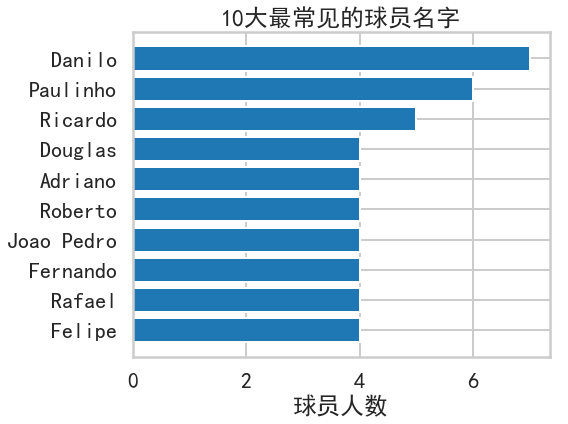

In [16]:
# 列出数量最多的球员名字
top_num = 10

top_counts_name = player.groupby('player_name',as_index=False).count().sort_values('player_api_id',ascending=False).head(top_num)

fig, ax = plt.subplots(figsize=(8,6))

ax.barh(np.arange(top_num), top_counts_name['player_api_id'].values, align = 'center')

ax.set_yticks(np.arange(top_num))
ax.set_yticklabels(top_counts_name['player_name'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('球员人数')
ax.set_title('{}大最常见的球员名字'.format(top_num))

plt.tight_layout()

其中叫Danilo（达尼诺）的球员最多，一共有7位；叫Paulinho（保利尼奥）的排第二，一共有6位；叫Ricardo（里卡多）的排第三。

#### 4.3 球员生日
出生日期为1989年3月2日的球员最多，有10名球员。

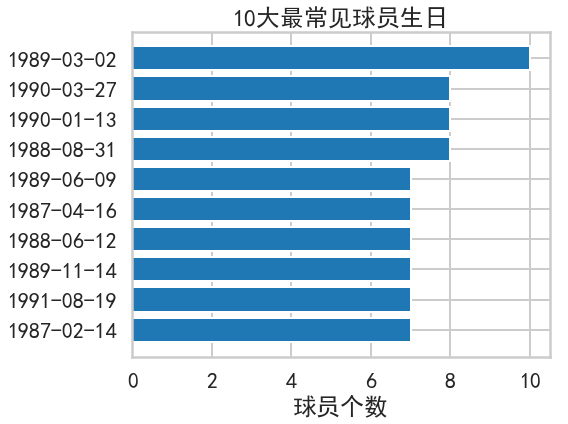

In [17]:
# 列出数量最多的球员生日
top_num = 10

top_counts_birthday = player.groupby('birthday',as_index=False).count().sort_values('player_api_id',ascending=False).head(top_num)

fig, ax = plt.subplots(figsize=(8,6))

ax.barh(np.arange(top_num), top_counts_birthday['player_api_id'].values, align = 'center')

ax.set_yticks(np.arange(top_num))
ax.set_yticklabels([i[:-9] for i in top_counts_birthday['birthday'].values])
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xlabel('球员个数')
ax.set_title('{}大最常见球员生日'.format(top_num))

import matplotlib.dates as mdates
#myFmt = mdates.DateFormatter('%d')
#ax.yaxis.set_major_formatter(myFmt)

plt.tight_layout()

#### 4.3.1 相对年龄效应（出生月份偏见）

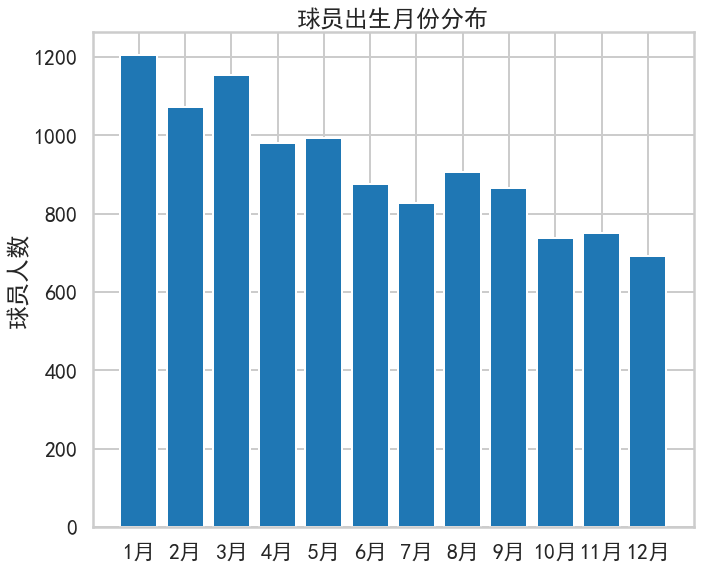

In [18]:
player['birthday'] = pd.to_datetime(player['birthday'], yearfirst=True)
player['month'] = [i.month for i in player['birthday']]

month_name = ['1月', '2月', '3月', '4月', '5月', '6月', '7月', '8月', '9月', '10月', '11月', '12月']

month_gby = player.groupby(by='month', as_index=False).count()

fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(month_gby['month'], month_gby['birthday'], align = 'center')

ax.set_xticks(month_gby['month'])
ax.set_xticklabels(month_name)
#ax.set_yticklabels(ax.get_xticks())
ax.set_ylabel('球员人数')
ax.set_title('球员出生月份分布'.format(top_num))

plt.tight_layout()

这一结果验证了[相对年龄效应](https://en.wikipedia.org/wiki/Relative_age_effect)。这一效应说的是在职业球员中某些月份出生的球员更多，而其他月份出生的球员较少。

青少年体育比赛通常以年为单位，把球员划分成不同的年龄段。但是即使是在同一个年龄段中，最小的球员和最大的球员也有可能相差接近1岁。因此，年龄较大的球员在同年龄段中会因为身体上的优势而获得更多的比赛机会，这有助于其成长为职业球员。而年龄较小的球员会因为身体上的劣势导致比赛机会较少，从而更难脱颖而出。

国际青少年足球比赛通常以1月1日来划分年龄段，因此1月份出生的小孩在同年龄段中属于年龄较大的球员，更有可能成长为职业球员。而十二月份出生的球员在同年龄段中属于年龄较小的球员，因此成长道路更为艰辛。这样就造成了在职业球员中一月份出生的球员最多，十二月份出生的球员最少，如上面的数据统计所示。

这也造成了表面上的对球员出生月份的偏见：人们会误认为是因为1月份出生的小孩更适合踢球才导致了1月份出生的球员多。

那么如何说明是1月份出生的小孩并没有更适合踢球呢？

事实上，不同的年龄段划分日期会导致不同的效应。比如，英国足球以9月1日来划分年龄段，因此造成的结果就是九、十月份出生的球员就最多，而不是一月份。（参见下图和[The Science of Soccer](https://www.amazon.com/Science-Soccer-John-Wesson/dp/0750308133)）。这就是人为划分年龄段造成人为选择的一个证据。

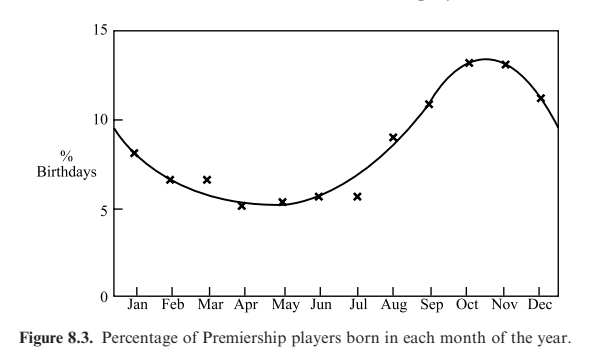


#### 如何利用相对年龄效应？

当我们知道有相对年龄效应后，应该怎么做才能更有效率地培养年轻球员呢？下面简单说几点建议：

* 足协层面要尽量消除相对年龄效应，这样才能使得真正更加优秀的球员在公平的环境中脱颖而出。比如，在保证公平的前提下，可以用身体发育状况来划分年龄段，而不只是用年龄大小来划分。现在的比利时足协就是这么操作的，身体发育较晚的球员获得批准后可以参加低年龄段的比赛，以保证得到足够的锻炼机会。

* 俱乐部层面也要尽量消除相对年龄效应，这样才能使得自己的青训人才输出效率最大化。

* 对于家长来讲，一是可以利用这一效应，尽量让自己的孩子出生在上半年。如果已经无法利用这一效应，那么就需要慎重选择一个合适的平台，考虑的重点将是自己的孩子能否在这一平台上得到足够多的锻炼机会，能否得到足够多的出场机会。这对于大月份出生的孩子至关重要。

#### 4.4 球员身高
球员身高符合高斯分布，平均身高为1.82米。

欧洲职业球员的平均身高为1.82米。
最矮的球员是Juan Quero，身高为1.57米。
最高的球员是Kristof van Hout，身高为2.08米。


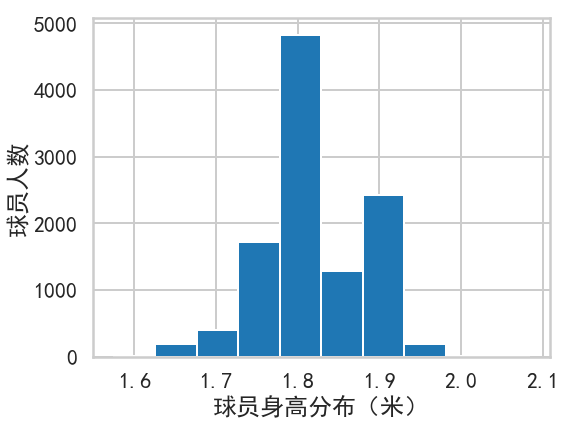

In [19]:
plt.figure(figsize=(8,6))
plt.hist(player['height']/100, bins=10)
plt.xlabel('球员身高分布（米）')
plt.ylabel('球员人数')

print('欧洲职业球员的平均身高为{:.2f}米。'.format(player['height'].mean()/100))
print('最矮的球员是{}，身高为{:.2f}米。'.format(player[player.height==np.min(player.height)].player_name.values[0],
                                                               np.min(player.height)/100))
print('最高的球员是{}，身高为{:.2f}米。'.format(player[player.height==np.max(player.height)].player_name.values[0],
                                                              np.max(player.height)/100))

plt.tight_layout()

#### 4.5 球员体重

球员体重也符合高斯分布，平均体重为76.4公斤。

欧洲职业球员的平均体重为76.4公斤。
最轻的球员是Juan Quero，体重为53.1公斤。
最重的球员是Kristof van Hout，体重为110.2公斤。


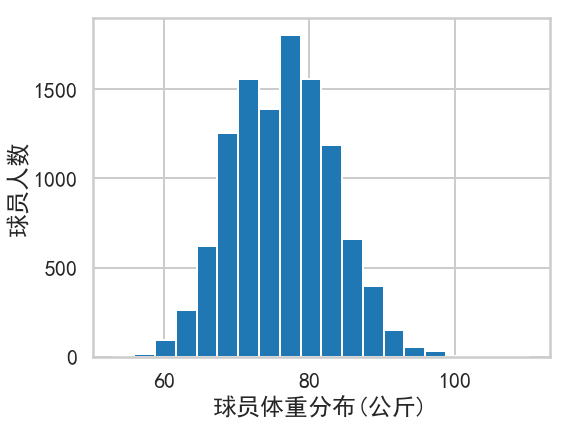

In [20]:
plt.figure(figsize=(8,6))
plt.hist(player['weight']*0.4536, bins=20)
plt.xlabel('球员体重分布(公斤)')
plt.ylabel('球员人数')

print('欧洲职业球员的平均体重为{:.1f}公斤。'.format(player['weight'].mean()*0.4536))
print('最轻的球员是{}，体重为{:.1f}公斤。'.format(player[player.weight==np.min(player.weight)].player_name.values[0], np.min(player.weight)*0.4536))
print('最重的球员是{}，体重为{:.1f}公斤。'.format(player[player.weight==np.max(player.weight)].player_name.values[0], np.max(player.weight)*0.4536))

plt.tight_layout()
#plt.savefig('weight',dpi=400)

第一部分完。

[第二部分：职业足球比赛的进球数规律](https://github.com/xzl524/football_data_analysis/blob/master/projects/european_soccer_database_analysis/exploratory_data_analysis/exploratory_data_analysis_2_CN.ipynb)。